In [1]:
import gzip
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pycountry
from functools import lru_cache

import os
import torch
from PIL import Image
import albumentations as A
from torch.utils.data import Dataset, DataLoader
from albumentations.pytorch import ToTensorV2
from sklearn.metrics import accuracy_score, f1_score
import onnxruntime as ort

In [2]:
file_path = 'links.tsv.gz'

with gzip.open(file_path, 'rt', encoding='utf-8') as file:
    df = pd.read_csv(file, sep='\t')

df

,id,label,nationality,date_of_birth,year_of_birth,image
0,Q261019,Isabelle Boulay,canada,1972-07-06T00:00:00Z,1972,https://upload.wikimedia.org/wikipedia/commons...
1,Q261049,Florencia Peña,argentina,1974-11-07T00:00:00Z,1974,https://upload.wikimedia.org/wikipedia/commons...
2,Q261064,Colin Fleming,united_kingdom,1984-08-13T00:00:00Z,1984,https://upload.wikimedia.org/wikipedia/commons...
3,Q261069,Stig Inge Bjørnebye,norway,1969-12-11T00:00:00Z,1969,https://upload.wikimedia.org/wikipedia/commons...
4,Q261123,Alireza Haghi,iran,1979-02-08T00:00:00Z,1979,https://upload.wikimedia.org/wikipedia/commons...
...,...,...,...,...,...,...
311596,Q61045974,Genc Sermaxhaj,kosovo,1988-12-28T00:00:00Z,1988,https://upload.wikimedia.org/wikipedia/commons...
311597,Q61093547,Alfonso Méndiz,spain,1961-07-21T00:00:00Z,1961,https://upload.wikimedia.org/wikipedia/commons...
311598,Q61163004,Carmen Aída Lazo,el_salvador,1976-01-03T00:00:00Z,1976,https://upload.wikimedia.org/wikipedia/commons...
311599,Q61315007,Christin Walker,united_states_of_america,1988-05-03T00:00:00Z,1988,https://upload.wikimedia.org/wikipedia/commons...


## Аналитика

In [3]:
df.describe()

,year_of_birth
count,311601.000000
mean,1964.101880
std,20.576533
min,1920.000000
25%,1949.000000
50%,1966.000000
75%,1982.000000
max,2233.000000


### Посмотрим распределение целевой переменной

In [4]:
print(df['nationality'].unique().size)
np.unique(df['nationality'])

405


array(['afghan', 'afghanistan', 'afrika', 'albania', 'algeria',
       'american_occupation_zone', 'american_samoa', 'americans',
       'andorra', 'angola', 'anguilla', 'antigua_and_barbuda',
       'argentina', 'armenia', 'armenian_soviet_socialist_republic',
       'artsakh', 'aruba', 'assam', 'australia', 'austria', 'austrians',
       'azerbaijan', 'azerbaijani', 'bahamas', 'bahrain', 'bangladesh',
       'bangladeshis', 'barbados', 'beiyang_government', 'belarus',
       'belgian_congo', 'belgium', 'belize', 'benin', 'bermuda', 'bhutan',
       'bicycle_kick', 'bolivia', 'bosnia_and_herzegovina', 'bosniaks',
       'botswana', 'brazi', 'brazil', 'brazil–uruguay_relations',
       'british_empire', 'british_hong_kong',
       'british_national_(overseas)', 'british_people', 'british_raj',
       'british_somaliland', 'british_virgin_islands', 'brunei',
       'bulgaria', 'bulgarian', 'burkina_faso', 'burundi',
       'byelorussian_soviet_socialist_republic', 'cambodia', 'cameroon'

In [5]:
nationality_counts = df['nationality'].value_counts() # это чисто для графика, чтобы было красивее
nationality_counts

nationality
united_states_of_america       60341
germany                        23901
france                         17653
united_kingdom                 15495
italy                          12994
                               ...  
spain_under_the_restoration        1
british_virgin_islands             1
liberland                          1
croacia                            1
são_paulo                          1
Name: count, Length: 405, dtype: int64

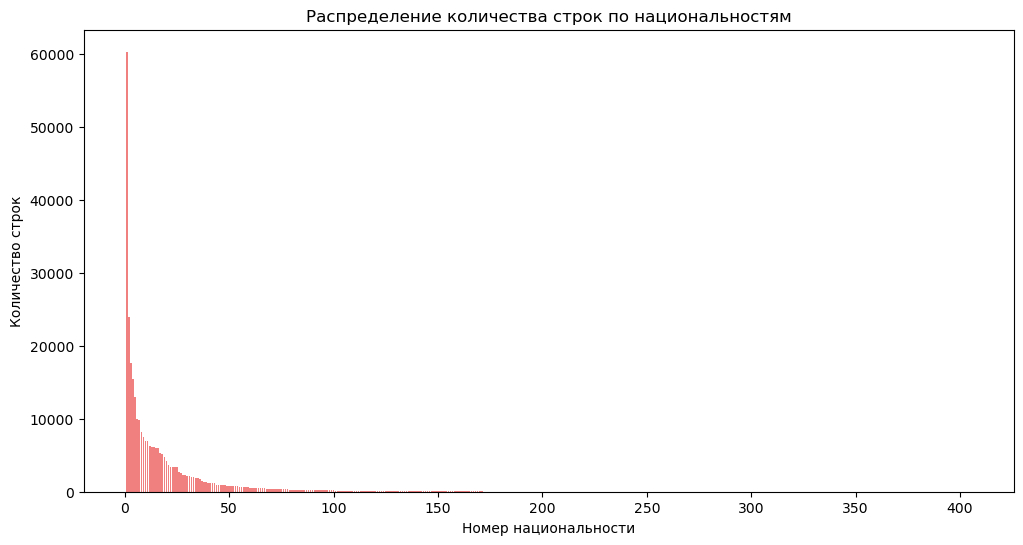

In [6]:
nationality_indices = range(1, len(nationality_counts) + 1)

plt.figure(figsize=(12, 6))
plt.bar(nationality_indices, nationality_counts.values, color='lightcoral')

plt.xlabel('Номер национальности')
plt.ylabel('Количество строк')
plt.title('Распределение количества строк по национальностям')

plt.show()

##### Большие выбросы сильно искажают данные => посмотрим медианные 80%, чтобы увеличить масштаб

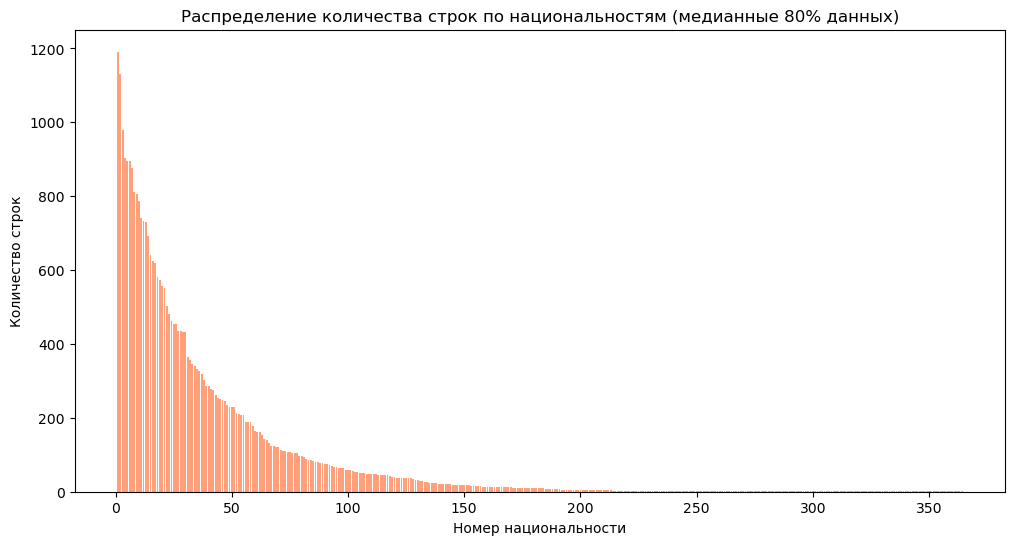

In [7]:
D1 = nationality_counts.quantile(0.1)
D9 = nationality_counts.quantile(0.9)

lower_bound = D1
upper_bound = D9

median_80_data = nationality_counts[
    (nationality_counts >= lower_bound) & (nationality_counts <= upper_bound)
]

filtered_indices = range(1, len(median_80_data) + 1)

plt.figure(figsize=(12, 6))
plt.bar(filtered_indices, median_80_data.values, color='lightsalmon')

plt.xlabel('Номер национальности')
plt.ylabel('Количество строк')
plt.title('Распределение количества строк по национальностям (медианные 80% данных)')

plt.show()

#### Дополнительно посмотрим распределение года рождения просто по приколу, изучить нереальные значения

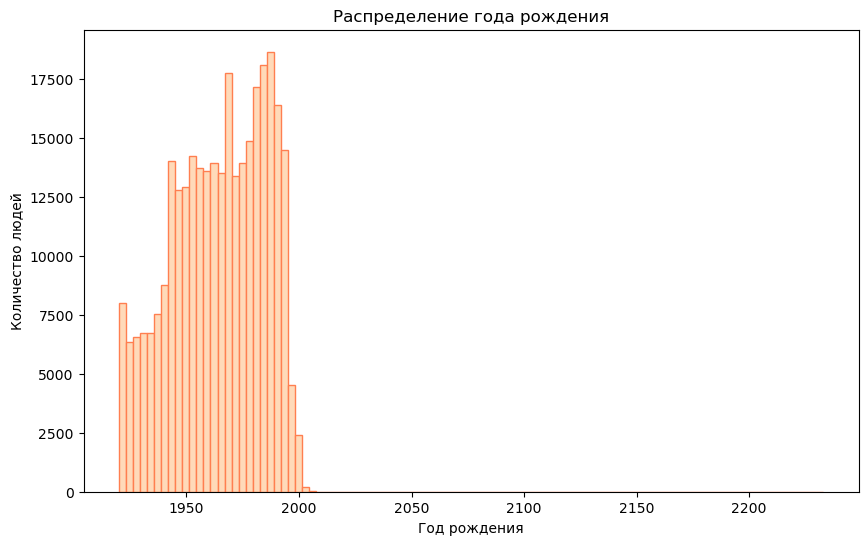

In [8]:
plt.figure(figsize=(10, 6))
plt.hist(df['year_of_birth'], bins=100, color='peachpuff', edgecolor='coral')

plt.xlabel('Год рождения')
plt.ylabel('Количество людей')
plt.title('Распределение года рождения')

plt.show()

In [9]:
df[df['year_of_birth'] > 2020]#['image'].values[0]

,id,label,nationality,date_of_birth,year_of_birth,image
87132,Q16311,James T. Kirk,united_states_of_america,2233-03-22T00:00:00Z,2233,https://upload.wikimedia.org/wikipedia/commons...
87133,Q16341,Spock,united_federation_of_planets,2230-01-01T00:00:00Z,2230,https://upload.wikimedia.org/wikipedia/commons...


##### Забавно, это персонажи научно-фантастического телесериала «Звёздный путь». Они нам никак не помешают, так что пусть остаются)

In [10]:
df[df['nationality'] == 'russia'] # ради интереса глянем своих

,id,label,nationality,date_of_birth,year_of_birth,image
13,Q262084,Lioubov Sokolova,russia,1977-12-04T00:00:00Z,1977,https://upload.wikimedia.org/wikipedia/commons...
46,Q263867,Vera Sokolova,russia,1987-06-08T00:00:00Z,1987,https://upload.wikimedia.org/wikipedia/commons...
94,Q266271,Sainkho Namtchylak,russia,1957-03-11T00:00:00Z,1957,https://upload.wikimedia.org/wikipedia/commons...
110,Q266930,Vladimir Chagin,russia,1970-01-05T00:00:00Z,1970,https://upload.wikimedia.org/wikipedia/commons...
220,Q272120,Elvira Khasyanova,russia,1981-03-28T00:00:00Z,1981,https://upload.wikimedia.org/wikipedia/commons...
...,...,...,...,...,...,...
311470,Q56676371,Daria Kan,russia,1998-09-28T00:00:00Z,1998,https://upload.wikimedia.org/wikipedia/commons...
311481,Q56876462,Anna Galliamova,russia,1986-02-27T00:00:00Z,1986,https://upload.wikimedia.org/wikipedia/commons...
311485,Q57079716,Kirill Karkach,russia,1990-07-08T00:00:00Z,1990,https://upload.wikimedia.org/wikipedia/commons...
311525,Q58860743,Vladislav Roslyakov,russia,2000-05-02T00:00:00Z,2000,https://upload.wikimedia.org/wikipedia/commons...


In [11]:
df[df['label'] == 'Vladimir Putin'] # большой брат следит за вами

,id,label,nationality,date_of_birth,year_of_birth,image
221348,Q7747,Vladimir Putin,soviet_union,1952-10-07T00:00:00Z,1952,https://upload.wikimedia.org/wikipedia/commons...


### Пошла возня...
##### Пробуем привести значения в `nationality` к единому +/- адекватному виду. Создадим для этого столбец `country`, который впоследствии и будем предсказывать.

Можно было заметить, что в столбце с так называемыми нациями в большинстве были указаны именно названия стран, а раз это архив википедии, то, недолго думая, можно прийти к выводу, что это страны происхождения (рождения) всех этих людей, потому что именно их обычно указывают на главной странице рядом с датой рождения и именем. Так что задача предсказания по фото постепенно сводится к предсказанию именно страны происхождения человека, а это уже звучит достаточно понятно и точно.

In [12]:
# начнем с умного подхода: поищем совпадения в библиотеке pycountry
@lru_cache(maxsize=None)
def map_to_country(name):
    try:
        country = pycountry.countries.search_fuzzy(name)[0]
        return country.name
    except LookupError:
        return None

df['country'] = df['nationality'].apply(map_to_country)

SubdivisionHierarchy(code='MX-MEX', country_code='MX', name='México', parent_code=None, type='State')
SubdivisionHierarchy(code='US-GA', country_code='US', name='Georgia', parent_code=None, type='State')
SubdivisionHierarchy(code='DJ-DJ', country_code='DJ', name='Djibouti', parent_code=None, type='City')
SubdivisionHierarchy(code='GB-ENG', country_code='GB', name='England', parent_code=None, type='Country')
SubdivisionHierarchy(code='PA-8', country_code='PA', name='Panamá', parent_code=None, type='Province')
SubdivisionHierarchy(code='GN-ML', country_code='GN', name='Mali', parent='L', parent_code='GN-L', type='Prefecture')
SubdivisionHierarchy(code='NG-NI', country_code='NG', name='Niger', parent_code=None, type='State')
SubdivisionHierarchy(code='GB-SCT', country_code='GB', name='Scotland', parent_code=None, type='Country')
SubdivisionHierarchy(code='BE-WLX', country_code='BE', name='Luxembourg', parent='WAL', parent_code='BE-WAL', type='Province')
SubdivisionHierarchy(code='LU-LU', 

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 311601 entries, 0 to 311600
Data columns (total 7 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   id             311601 non-null  object
 1   label          311601 non-null  object
 2   nationality    311601 non-null  object
 3   date_of_birth  311601 non-null  object
 4   year_of_birth  311601 non-null  int64 
 5   image          311601 non-null  object
 6   country        201313 non-null  object
dtypes: int64(1), object(6)
memory usage: 16.6+ MB


In [14]:
missing_countries = df[df['country'].isna()]
print(missing_countries['nationality'].unique().size)
missing_countries['nationality'].unique()

216


array(['united_kingdom', 'kingdom_of_the_netherlands',
       'united_states_of_america', 'new_zealand',
       'socialist_federal_republic_of_yugoslavia', 'czech_republic',
       'south_africa', "people's_republic_of_china", 'south_korea',
       'soviet_union', 'republic_of_china_(1912–1949)', 'turkey',
       'bosnia_and_herzegovina', 'democratic_republic_of_the_congo',
       'western_sahara', 'republic_of_macedonia', 'yugoslavia',
       'trinidad_and_tobago', 'ivory_coast', 'puerto_rico',
       'northern_ireland', 'saudi_arabia', 'republic_of_the_congo',
       'north_korea', 'antigua_and_barbuda', 'czechoslovakia',
       'sri_lanka', 'san_marino', 'dominican_republic',
       'state_of_palestine', 'burkina_faso',
       'federated_states_of_micronesia', 'second_polish_republic',
       'costa_rica', 'british_raj', 'german_democratic_republic',
       'québec-comté', 'united_arab_emirates', 'faroe_islands',
       'saint_kitts_and_nevis', 'hong_kong',
       "people's_republic

Получилось много пропусков (половина из всех изначальных), что ж, придется заполнять это самостоятельно, попросим нейросеть написать нам словарь на имеющиеся у него данные, остальные поищем вручную, нам же нечего делать...

In [15]:
manual_mapping = {
    'united_kingdom': 'United Kingdom',
    'kingdom_of_the_netherlands': 'Netherlands',
    'united_states_of_america': 'United States',
    'new_zealand': 'New Zealand',
    'socialist_federal_republic_of_yugoslavia': 'Yugoslavia',
    'czech_republic': 'Czech Republic',
    'south_africa': 'South Africa',
    "people's_republic_of_china": 'China',
    'south_korea': 'Korea', ###
    'soviet_union': 'Russian Federation',
    'republic_of_china_(1912–1949)': 'China',
    'turkey': 'Turkey',
    'bosnia_and_herzegovina': 'Bosnia and Herzegovina',
    'democratic_republic_of_the_congo': 'Democratic Republic of the Congo',
    'western_sahara': 'Western Sahara',
    'republic_of_macedonia': 'North Macedonia',
    'yugoslavia': 'Yugoslavia',
    'trinidad_and_tobago': 'Trinidad and Tobago',
    'ivory_coast': 'Côte d\'Ivoire',
    'greenland':'Canada',
    'puerto_rico': 'Puerto Rico',
    'northern_ireland': 'United Kingdom',
    'saudi_arabia': 'Saudi Arabia',
    'republic_of_the_congo': 'Congo',
    'palau':'Philippines', ###
    'montserrat':'Cuba', ###
    'north_korea': 'Korea', ###
    'antigua_and_barbuda': 'Antigua and Barbuda',
    'liechtenstein':'Israel', ###
    'czechoslovakia': 'Czech Republic',
    'sri_lanka': 'Sri Lanka',
    'san_marino': 'San Marino',
    'dominican_republic': 'Dominican Republic',
    'state_of_palestine': 'Palestine, State of',
    'burkina_faso': 'Burkina Faso',
    'federated_states_of_micronesia': 'Micronesia, Federated States of',
    'second_polish_republic': 'Poland',
    'costa_rica': 'Costa Rica',
    'british_raj': 'India',
    'german_democratic_republic': 'Germany',
    'united_arab_emirates': 'United Arab Emirates',
    'faroe_islands': 'United Kingdom', ###
    'saint_kitts_and_nevis': 'Saint Kitts and Nevis',
    'hong_kong': 'China', ###
    "people's_republic_of_poland": 'Poland',
    'serbia_and_montenegro': 'Serbia',
    'nazi_germany': 'Germany',
    'el_salvador': 'El Salvador',
    'central_african_republic': 'Central African Republic',
    'kingdom_of_yugoslavia': 'Yugoslavia',
    'weimar_republic': 'Germany',
    'kingdom_of_denmark': 'Denmark',
    'saint_vincent_and_the_grenadines': 'Saint Vincent and the Grenadines',
    'papua_new_guinea': 'Papua New Guinea',
    'cape_verde': 'Cabo Verde',
    'palestinian_national_authority': 'Palestine, State of',
    'empire_of_japan': 'Japan',
    'sierra_leone': 'Sierra Leone',
    'east_timor': 'Indonesia', ###
    'russian_soviet_federative_socialist_republic': 'Russian Federation',
    'kingdom_of_serbs,_croatians_and_slovenes': 'Yugoslavia',
    'tibet': 'China',
    'mandatory_palestine': 'Palestine, State of',
    'kingdom_of_italy': 'Italy',
    'turkish_republic_of_northern_cyprus': 'Cyprus',
    'kingdom_of_romania': 'Romania',
    'guernsey':'United Kingdom', ###
    'equatorial_guinea': 'Equatorial Guinea',
    'transnistria': 'Romania',
    'great_britain': 'United Kingdom',
    'kingdom_of_iraq': 'Iraq',
    'south_sudan': 'Sudan',
    'ukrainian_soviet_socialist_republic': 'Ukraine',
    'são_tomé_and_príncipe': 'São Tomé and Príncipe',
    'artsakh': 'Azerbaijan',
    'federal_republic_of_yugoslavia': 'Yugoslavia',
    'armenian_soviet_socialist_republic': 'Armenia',
    'kingdom_of_egypt': 'Egypt',
    'francoist_spain': 'Spain',
    'protectorate_of_bohemia_and_moravia': 'Czech Republic',
    'west_germany': 'Germany',
    'solomon_islands': 'Solomon Islands',
    'saint_lucia': 'Saint Lucia',
    'colonial_nigeria': 'Nigeria',
    'kingdom_of_hungary': 'Hungary',
    "people's_republic_of_hungary": 'Hungary',
    'south_vietnam': 'Vietnam',
    'isle_of_man': 'United Kingdom', ###
    'manchukuo': 'China',
    'laos': 'Laos',
    'czechoslovak_socialist_republic': 'Czech Republic',
    'british_hong_kong': 'China',
    'slovak_state_(1939-1945)': 'Slovakia',
    'kingdom_of_bulgaria': 'Bulgaria',
    "people's_republic_of_bulgaria": 'Bulgaria',
    'sultanate_of_zanzibar': 'Tanzania, United Republic of', ###
    'dutch_east_indies': 'Indonesia',
    'french_algeria': 'Algeria',
    'marshall_islands': 'Marshall Islands',
    'byelorussian_soviet_socialist_republic': 'Belarus',
    'japanese_people': 'Japan',
    'welsh_people': 'United Kingdom',
    'british_people': 'United Kingdom',
    'rhodesia': 'Zimbabwe',
    'hungarian': 'Hungary',
    'federation_of_rhodesia_and_nyasaland': 'Zimbabwe',
    'socialist_republic_of_romania': 'Romania',
    'kingdom_of_albania': 'Albania',
    'iraqi_kurdistan': 'Iraq',
    'union_of_south_africa': 'South Africa',
    'indian_people': 'India',
    'cook_islands': 'New Zealand', ###
    'niue': 'New Zealand', ### 
    'georgian_soviet_socialist_republic': 'Georgia',
    'southern_rhodesia': 'Zimbabwe',
    'british_virgin_islands': 'United States',
    'american_samoa': 'United States',
    'danish': 'Denmark',
    'kingdom_of_afghanistan': 'Afghanistan',
    'first_republic_of_austria': 'Austria',
    'british_empire': 'United Kingdom',
    'kingdom_of_greece': 'Greece',
    'belgian_congo': 'Democratic Republic of the Congo',
    'macau': 'China',
    "people's_socialist_republic_of_albania": 'Albania',
    'yemen_arab_republic': 'Yemen',
    'vatican_city': 'Italy',
    'kenya_colony': 'Kenya',
    'tibet_from_1912_to_1951': 'China',
    'ruanda-urundi': 'Rwanda',
    'german_empire': 'Germany',
    'nepali': 'Nepal',
    'united_kingdom_of_great_britain_and_ireland': 'United Kingdom',
    'tuva_republic': 'Russian Federation',
    'austrians': 'Austria',
    'british_national_(overseas)': 'United Kingdom',
    'filipino_people': 'Philippines',
    'lithuanian_soviet_socialist_republic': 'Lithuania',
    'country_of_the_kingdom_of_the_netherlands': 'Netherlands',
    'netherlands_antilles': 'Netherlands',
    'republic_of_upper_volta': 'Burkina Faso',
    'first_portuguese_republic': 'Portugal',
    "romanian_people's_republic": 'Romania',
    "mongolian_people's_republic": 'Mongolia',
    'democratic_republic_of_georgia': 'Georgia',
    'azerbaijani': 'Azerbaijan',
    'bangladeshis': 'Bangladesh',
    'bulgarian': 'Bulgaria',
    'italians': 'Italy',
    'american_occupation_zone': 'Germany',
    'republic_of_cuba_(1902–59)': 'Cuba',
    'south_yemen': 'Yemen',
    'irish_republic': 'Ireland',
    'british_somaliland': 'Somalia',
    'chinese_taipei': 'China',
    'bosniaks': 'Bosnia and Herzegovina',
    'tibetan_people': 'China',
    'kingdom_of_mysore': 'India',
    'beiyang_government': 'China',
    'afrika': 'South Africa',
    'americans': 'United States',
    'chileans': 'Chile',
    'sint_maarten': 'Netherlands',
    'hungarians': 'Hungary',
    'norwegian': 'Norway',
    'irish': 'Ireland',
    'czechoslovak_republic': 'Czech Republic',
    'mexicana': 'Mexico',
    'cayman_islands': 'Cuba',
    'são_paulo': 'Brazil',
    'québec-comté': 'Canada',
    'israelis': 'Israel',
    'range_of_andia': 'Spain',
    'anguilla':'Cuba',
    'marítimo': 'Portugal',
    'chilena': 'Chile',
    'canadian_french': 'Canada',
    'egyptians': 'Egypt',
    'francia': 'France',
    'ukrainians': 'Ukraine',
    'dominicana': 'Dominican Republic',
    'kurdistan': 'Turkey',
    'germans': 'Germany',
    'the_republic_of_abkhazia': 'Georgia', #### упс...
    'united_federation_of_planets': 'United States', # легенда
    'katun': 'Russian Federation',
    'siciliana': 'Italy',
    'soviètic': 'Russian Federation',
    'first_hungarian_republic': 'Hungary',
    'staffanstorp_municipality': 'Sweden',
    'nuu-chah-nulth': 'Canada',
    'croacia': 'Croatia',
    'liberland': 'Czech Republic',
    'spain_under_the_restoration': 'Spain',
    'venezolano.': 'Venezuela, Bolivarian Republic of',
    'estado_novo': 'Portugal',
    'ivanteyevskaya_street': 'Russian Federation',
    'kuwait_city': 'Kuwait',
    'florence': 'Italy',
    'monterrey': 'Mexico',
    'moldova':'Romania', ###
    'colombiana': 'Colombia',
    'ss_france': 'France',
    'francais_objective_specifique': 'France',
    'mexico_city': 'Mexico',
    'morocco_pavilion': 'Morocco',
    'brazil–uruguay_relations': 'Brazil',
    'ecuador_national_football_team': 'Ecuador',
    'langnau_am_albis': 'Switzerland',
    "federal_people's_republic_of_yugoslavia": 'Yugoslavia',
    'third_czechoslovak_republic': 'Czech Republic',
    'plastin': 'Romania',
    'nazareth': 'Israel',
    'korea':'Korea', ###
    'suisse_romande': 'Switzerland',
    'republika_srpska': 'Bosnia and Herzegovina',
    'san_luis_potosí': 'Mexico',
    'república_de_síria': 'Syrian Arab Republic',
    'tamil_eelam': 'Sri Lanka',
    'sockel_fm2+': 'Spain', # немного непонятно при чем тут розетка...
    'canadian_nationality_law': 'Canada',
    'bicycle_kick': 'Chile',
    'santo_domingo': 'Dominican Republic',
    'québécois': 'Canada',
}

In [16]:
# всего 2 часа потраченного времени, и вот он - самый большой словарь стран
df['country'] = df['nationality'].map(manual_mapping).combine_first(df['country'])

In [17]:
df[df['country'].isna()]

,id,label,nationality,date_of_birth,year_of_birth,image,country
171177,Q18175132,Eliana Rubashkyn,statelessness,1988-06-25T00:00:00Z,1988,https://upload.wikimedia.org/wikipedia/commons...,None
171460,Q18591201,Glen L Roberts,statelessness,1962-05-05T00:00:00Z,1962,https://upload.wikimedia.org/wikipedia/commons...,None
187439,Q1187597,Denis Pécic,statelessness,1928-10-08T00:00:00Z,1928,https://upload.wikimedia.org/wikipedia/commons...,None
257922,Q15141696,Twilight Sparkle,equestria,1998-08-23T00:00:00Z,1998,https://upload.wikimedia.org/wikipedia/commons...,None


Остались совсем уникальные случаи, мне было не лень посмотреть и их...

In [18]:
df.loc[df["label"] == "Eliana Rubashkyn", "country"] = "Colombia"
df.loc[df["label"] == "Glen L Roberts", "country"] = "United States"
df.loc[df["label"] == "Denis Pécic", "country"] = "France"

In [19]:
df[df['country'].isna()]['image'].values[0]

'https://upload.wikimedia.org/wikipedia/commons/thumb/0/0d/Twilight_Sparkle_Cuttie_Mark.svg/200px-Twilight_Sparkle_Cuttie_Mark.svg'

Эту малышку придется дропнуть, чтобы не портила статистику, но Искорка в наших сердцах...

In [20]:
df = df.dropna(subset=['country'])

#### Итак, итоговое распределение по странам:

In [21]:
print(df['country'].unique().size)
df['country'].unique()

196


array(['Canada', 'Argentina', 'United Kingdom', 'Norway',
       'Iran, Islamic Republic of', 'Netherlands', 'United States',
       'New Zealand', 'Greece', 'Sweden', 'Germany', 'Russian Federation',
       'Estonia', 'Ukraine', 'Nigeria', 'Jamaica',
       'Venezuela, Bolivarian Republic of', 'Denmark', 'Switzerland',
       'Finland', 'France', 'Belgium', 'Romania', 'Italy', 'Poland',
       'India', 'Ireland', 'Yugoslavia', 'Japan', 'Hungary',
       'Czech Republic', 'South Africa', 'Mexico', 'Australia', 'Chile',
       'Israel', 'Austria', 'Spain', 'Lebanon', 'China', 'Korea',
       'Serbia', 'Georgia', 'Croatia', 'Turkey', 'Brazil', 'Portugal',
       'Senegal', 'Belarus', 'Nicaragua', 'Bulgaria', 'Colombia',
       'Thailand', 'Slovenia', 'Latvia', 'Bosnia and Herzegovina',
       'Democratic Republic of the Congo', 'Western Sahara', 'Cyprus',
       'Albania', 'Lithuania', 'Taiwan, Province of China', 'Uruguay',
       'North Macedonia', 'Iceland', 'Peru', 'Trinidad and Toba

#### Посмотрим, как поменялся график

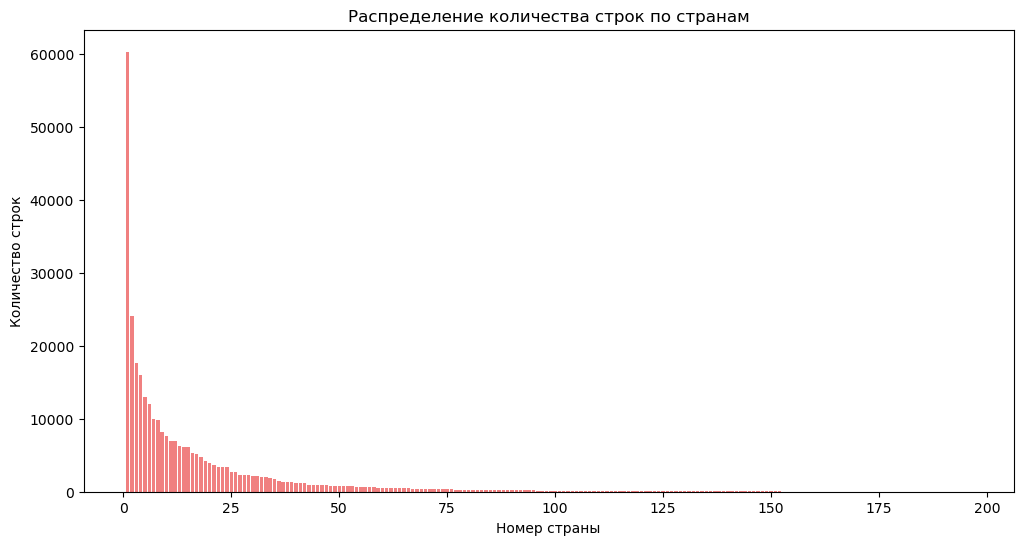

In [22]:
country_counts = df['country'].value_counts()

country_indices = range(1, len(country_counts) + 1)

plt.figure(figsize=(12, 6))
plt.bar(country_indices, country_counts.values, color='lightcoral')

plt.xlabel('Номер страны')
plt.ylabel('Количество строк')
plt.title('Распределение количества строк по странам')

plt.show()

#### Все еще есть длинный хвост стран с малекьким количеством строк. Попробуем сгруппировать редкие страны (где меньше 50 строк) по географическому признаку, сократив таким образом количество классов и увеличив количество данных для малых классов. Это повысит наши шансы нормально обучить модель. Снова прибегнем к словарю.

In [23]:
filtered_counts = country_counts[country_counts < 50] 
filtered_counts

country
Cabo Verde                          49
Yemen                               49
Gambia                              49
Madagascar                          48
Tuvalu                              45
Kyrgyzstan                          44
Barbados                            43
Bahamas                             41
Gabon                               38
Liberia                             38
Sierra Leone                        37
Mozambique                          36
Eritrea                             35
Togo                                32
Samoa                               31
Mauritius                           29
Botswana                            28
Central African Republic            26
Guyana                              25
Laos                                22
San Marino                          22
Tajikistan                          21
Monaco                              21
Grenada                             20
Antigua and Barbuda                 20
Mauritania       

In [24]:
# словарь для группировки редких стран
country_groups = {
    'Caribbean': [
        'Antigua and Barbuda', 'Bahamas', 'Barbados', 
        'Grenada', 'Saint Kitts and Nevis', 'Saint Lucia',
        'Saint Vincent and the Grenadines', 'Aruba', 'Bermuda',
        'Belize', 'Guyana'
    ],
    'Pacific Islands': [
        'Kiribati', 'Marshall Islands', 'Micronesia, Federated States of',
        'Nauru', 'Guam', 'Solomon Islands', 'Tuvalu', 'Vanuatu',
        'Papua New Guinea', 'Samoa'
    ],
    'African Small States': [
        'Botswana', 'Burundi', 'Cabo Verde', 'Comoros',
        'Djibouti', 'Equatorial Guinea', 'Eswatini', 'Gabon', 'Gambia', 'Eritrea',
        'Guinea-Bissau', 'Lesotho', 'Malawi', 'Mauritania', 'Mauritius', 'Mozambique',
        'São Tomé and Príncipe', 'Seychelles', 'Togo', 'Madagascar',
        'Central African Republic', 'Chad', 'Sierra Leone', 'Liberia'                               
    ],
    'Central Asia': [
        'Kyrgyzstan', 'Tajikistan', 'Turkmenistan', 'Uzbekistan'
    ],
    'Middle East Small States': [
        'Brunei Darussalam', 'Oman', 'Qatar', 'Western Sahara', 'Yemen'
    ],
    'Other Europe': [
        'Gibraltar', 'Monaco', 'San Marino'
    ],
    'Other Asia': [
        'Bhutan', 'Maldives', 'Laos', 'Vietnam'
    ]
}

In [25]:
keep_individual = country_counts[country_counts > 49].index.tolist() #названия стран где 50 и больше строк не меняем
def group_country(country):
    if country in keep_individual:
        return country
    for group, countries in country_groups.items():
        if country in countries:
            return group
    return 'Other'  #на всякий случай

df.loc[:, 'country'] = df['country'].apply(group_country)

In [26]:
print(df['country'].unique().size)
df['country'].unique()

144


array(['Canada', 'Argentina', 'United Kingdom', 'Norway',
       'Iran, Islamic Republic of', 'Netherlands', 'United States',
       'New Zealand', 'Greece', 'Sweden', 'Germany', 'Russian Federation',
       'Estonia', 'Ukraine', 'Nigeria', 'Jamaica',
       'Venezuela, Bolivarian Republic of', 'Denmark', 'Switzerland',
       'Finland', 'France', 'Belgium', 'Romania', 'Italy', 'Poland',
       'India', 'Ireland', 'Yugoslavia', 'Japan', 'Hungary',
       'Czech Republic', 'South Africa', 'Mexico', 'Australia', 'Chile',
       'Israel', 'Austria', 'Spain', 'Lebanon', 'China', 'Korea',
       'Serbia', 'Georgia', 'Croatia', 'Turkey', 'Brazil', 'Portugal',
       'Senegal', 'Belarus', 'Nicaragua', 'Bulgaria', 'Colombia',
       'Thailand', 'Slovenia', 'Latvia', 'Bosnia and Herzegovina',
       'Democratic Republic of the Congo', 'Middle East Small States',
       'Cyprus', 'Albania', 'Lithuania', 'Taiwan, Province of China',
       'Uruguay', 'North Macedonia', 'Iceland', 'Peru',
       '

#### Итак, наш список сократился до 144 стран (классов), где не менее 45 строк в каждом (можно проверить)

In [27]:
df['country'].value_counts()

country
United States     60348
Germany           24165
France            17659
United Kingdom    16044
Italy             13042
                  ...  
Tonga                52
Benin                52
Zambia               50
Rwanda               50
Other Europe         47
Name: count, Length: 144, dtype: int64

## Загрузка датасета

In [ ]:
notebook_path = "DownloadDataset.ipynb"
!jupyter nbconvert --to notebook --execute "{notebook_path}" --inplace --ExecutePreprocessor.timeout=-1

## Загрузка датасета из архива

P.S. Если выполнили предыдущий пункт, то этот можно пропустить

In [ ]:
notebook_path_1 = "Auxiliary.ipynb"
!jupyter nbconvert --to notebook --execute "{notebook_path_1}" --inplace --ExecutePreprocessor.timeout=-1

## Обучение моделей

In [ ]:
notebook_path_2 = "model_beit.ipynb"
!jupyter nbconvert --to notebook --execute "{notebook_path_2}" --inplace --ExecutePreprocessor.timeout=-1

In [ ]:
notebook_path_3 = "model_swin.ipynb"
!jupyter nbconvert --to notebook --execute "{notebook_path_3}" --inplace --ExecutePreprocessor.timeout=-1

In [ ]:
notebook_path_4 = "model_vit.ipynb"
!jupyter nbconvert --to notebook --execute "{notebook_path_4}" --inplace --ExecutePreprocessor.timeout=-1

## A

In [2]:
test_transform = A.Compose([
    A.Resize(224, 224),
    A.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
    ToTensorV2()
])

In [3]:
class CustomDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.classes = sorted(os.listdir(root_dir))
        self.class_to_idx = {cls: i for i, cls in enumerate(self.classes)}
        self.get_class = {i: cls for i, cls in enumerate(self.classes)}
        self.samples = []
        self.transform = transform

        for cls in self.classes:
            cls_dir = os.path.join(root_dir, cls)
            for img_name in os.listdir(cls_dir):
                self.samples.append((
                    os.path.join(cls_dir, img_name),
                    self.class_to_idx[cls]
                ))
        self.targets = np.unique([label for _, label in self.samples])

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_path, label = self.samples[idx]
        image = np.array(Image.open(img_path).convert("RGB"))

        if self.transform:
            augmented = self.transform(image=image)
            image = augmented["image"]

        return image, torch.tensor(label, dtype=torch.long)

In [4]:
test_dataset = CustomDataset(
    "split_dataset",
    transform=test_transform
)
test_loader = DataLoader(
    test_dataset,
    batch_size=64,
    shuffle=False,
    num_workers=4
)

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model = torch.jit.load("model_swin.pt")
# Validation
model.eval()
val_loss = 0
val_preds = []
val_labels = []

for images, labels in test_loader:
    for image in images:
        outputs = model(image.unsqueeze(0))

        preds = torch.argmax(outputs, dim=1)
        val_preds.extend(preds.cpu().numpy())
        val_labels.extend(labels.cpu().numpy())


In [ ]:
# Загружаем модель
session = ort.InferenceSession("models/beit_model.onnx")  # или decoder.onnx

image = Image.open("img.png").convert("RGB")
input_tensor = test_transform(image).unsqueeze(0).numpy()  # shape: (1, 3, 224, 224)
# Входные имена и инференс
input_name = session.get_inputs()[0].name
output_name = session.get_outputs()[0].name

outputs = session.run([output_name], {input_name: input_tensor})
print(outputs[0].shape)
print(test_dataset.get_class[int(torch.argmax(torch.tensor(outputs[0]), dim=1))])

In [5]:
session = ort.InferenceSession("models/beit_model.onnx", providers=['CPUExecutionProvider'])
input_name = session.get_inputs()[0].name
output_name = session.get_outputs()[0].name

all_preds = []
all_labels = []

for X, y in test_loader:
    ort_inputs = {input_name: X.numpy()}
    ort_outs = session.run([output_name], ort_inputs)

    preds = np.argmax(ort_outs[0], axis=1)
    all_preds.append(preds)
    all_labels.append(y.numpy())

# Конкатенация результатов
all_preds = np.concatenate(all_preds)
all_labels = np.concatenate(all_labels)

# Метрики
acc = accuracy_score(all_labels, all_preds)
f1 = f1_score(all_labels, all_preds, average='weighted')

print(f"Accuracy: {acc:.4f}")
print(f"F1 score: {f1:.4f}")

RuntimeError: DataLoader worker (pid(s) 24208, 17612, 23944, 17720) exited unexpectedly